<a href="https://colab.research.google.com/github/Arvind-55555/Measuring-CO-sequestration-of-a-tree/blob/main/Measuring_CO%E2%82%82_sequestration_of_a_tree_Model_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

**Generate More Realistic Data:**

**Species-Specific Parameters:** We use a dictionary to store species-specific growth rates, base carbon sequestration rates, optimal environmental parameters (temperature, rainfall, soil pH).

**Growth Modeling:** Tree DBH and Height is now dependent on the age and a growth curve derived from (1 + growth_rate * age) ** 0.5 model.

**Environmental Effects:** We simulate environmental data (temperature, rainfall, soil pH).

**CO2 Calculation:** The annual CO2 sequestration is calculated with the combined effect of temperature, rainfall and soil pH.

In [2]:
# 1. Generate More Realistic Hypothetical Data
np.random.seed(42)
n_samples = 1000

# Species-specific growth and carbon storage parameters
species_params = {
    'Oak': {'growth_rate': 0.03, 'base_carbon_seq': 0.18, 'optimal_temp': 18, 'optimal_rainfall': 100, 'optimal_soil_pH': 6.5},
    'Pine': {'growth_rate': 0.05, 'base_carbon_seq': 0.10, 'optimal_temp': 15, 'optimal_rainfall': 70, 'optimal_soil_pH': 5.5},
    'Maple': {'growth_rate': 0.04, 'base_carbon_seq': 0.15, 'optimal_temp': 20, 'optimal_rainfall': 90, 'optimal_soil_pH': 6.0},
    'Birch': {'growth_rate': 0.06, 'base_carbon_seq': 0.12, 'optimal_temp': 16, 'optimal_rainfall': 80, 'optimal_soil_pH': 5.0},
}

# Simulate tree data
species = np.random.choice(list(species_params.keys()), size=n_samples)
age = np.random.randint(1, 30, size=n_samples)
location = np.random.choice(['Urban', 'Forest', 'Rural'], size=n_samples)
temperature = np.random.uniform(10, 30, size=n_samples)
rainfall = np.random.uniform(50, 150, size=n_samples)
soil_pH = np.random.uniform(4.5, 7.5, size=n_samples)

In [3]:
# Function to calculate DBH and height based on age and species growth
def calculate_dimensions(species, age):
  growth_rate = species_params[species]['growth_rate']
  dbh = 5 * (1 + growth_rate * age) ** 0.5  # Adjusted to have initial growth and diminish over time
  height = 2 * (1 + growth_rate * age) ** 0.5
  return dbh, height

In [4]:
dbh = np.zeros(n_samples)
height = np.zeros(n_samples)
for i in range(n_samples):
  dbh[i], height[i] = calculate_dimensions(species[i], age[i])

In [5]:
# Calculate CO2 based on environment, species parameters
annual_co2_seq = np.zeros(n_samples)

In [6]:
for i in range(n_samples):
    species_p = species_params[species[i]]
    base_carbon_seq = species_p['base_carbon_seq']
    temp_effect = np.exp(-((temperature[i] - species_p['optimal_temp']) ** 2) / (2 * 5**2))
    rainfall_effect = np.exp(-((rainfall[i] - species_p['optimal_rainfall']) ** 2) / (2 * 30**2))
    soil_pH_effect = np.exp(-((soil_pH[i] - species_p['optimal_soil_pH']) ** 2) / (2 * 1**2))
    annual_co2_seq[i] = base_carbon_seq * (dbh[i]*height[i] ) * temp_effect * rainfall_effect * soil_pH_effect * (1 + species_p['growth_rate'])

In [7]:
df = pd.DataFrame({'species': species,
                   'age': age,
                   'location': location,
                   'temperature': temperature,
                   'rainfall': rainfall,
                   'soil_pH': soil_pH,
                   'dbh': dbh,
                   'height': height,
                   'annual_co2_seq': annual_co2_seq})

In [8]:
df.head(10)

,species,age,location,temperature,rainfall,soil_pH,dbh,height,annual_co2_seq
0,Maple,22,Forest,11.163276,50.135363,7.470327,6.855655,2.742262,0.086327
1,Birch,17,Forest,29.897326,79.980053,5.435638,7.106335,2.842534,0.049099
2,Oak,9,Rural,11.155611,114.645874,5.519916,5.634714,2.253886,0.506616
3,Maple,1,Rural,23.900705,147.419444,4.736818,5.099020,2.039608,0.086304
4,Maple,21,Urban,29.673579,134.706083,5.828394,6.782330,2.712932,0.143390
5,Birch,20,Urban,14.783602,52.359496,5.283146,7.416198,2.966479,1.707323
6,Oak,13,Forest,12.844987,139.856060,5.530160,5.894913,2.357965,0.391554
7,Oak,28,Rural,12.427699,128.319841,7.003715,6.782330,2.712932,1.034246
8,Maple,16,Rural,16.065503,128.037612,7.306454,6.403124,2.561250,0.357920
9,Pine,29,Rural,12.020916,95.799576,5.057199,7.826238,3.130495,1.349259


In [9]:
# 2. Data Preprocessing
X = df.drop('annual_co2_seq', axis=1)
y = df['annual_co2_seq']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_features = ['age', 'temperature', 'rainfall', 'soil_pH', 'dbh', 'height']
categorical_features = ['species', 'location']

In [10]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

In [11]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [12]:
# 3. Model Training (Random Forest and Gradient Boosting)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
gbr_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

In [13]:
# 4. Model Evaluation and Cross Validation
def evaluate_model(model, X, y, cv=5):
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)
    print(f"Cross-validation RMSE scores: {rmse_scores}")
    print(f"Average RMSE: {rmse_scores.mean():.2f}")
    return rmse_scores

In [14]:
print("Random Forest Performance")
rf_rmse_scores = evaluate_model(rf_model, X_train_processed, y_train)
rf_model.fit(X_train_processed, y_train)
rf_y_pred = rf_model.predict(X_test_processed)
rf_r2 = r2_score(y_test, rf_y_pred)
print(f"Random Forest Test R-squared: {rf_r2:.2f}")
print("\nGradient Boosting Performance")
gbr_rmse_scores = evaluate_model(gbr_model, X_train_processed, y_train)
gbr_model.fit(X_train_processed, y_train)
gbr_y_pred = gbr_model.predict(X_test_processed)
gbr_r2 = r2_score(y_test, gbr_y_pred)
print(f"Gradient Boosting Test R-squared: {gbr_r2:.2f}")

Random Forest Performance
Cross-validation RMSE scores: [0.29789348 0.26486505 0.28383046 0.30092876 0.2515396 ]
Average RMSE: 0.28
Random Forest Test R-squared: 0.72

Gradient Boosting Performance
Cross-validation RMSE scores: [0.31662813 0.27713882 0.31741722 0.29019665 0.29445367]
Average RMSE: 0.30
Gradient Boosting Test R-squared: 0.75


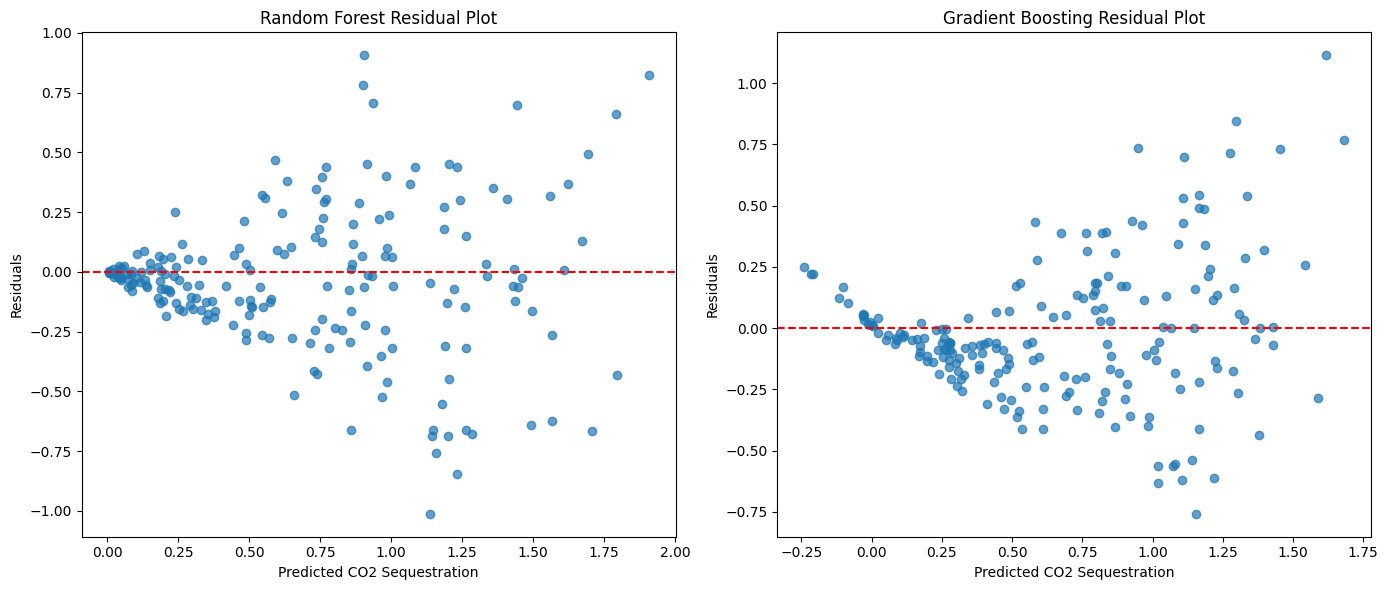

In [15]:
# 5. Analysis and Insights (Simplified)

# Compare residuals from both models
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

rf_residuals = y_test - rf_y_pred
gbr_residuals = y_test - gbr_y_pred

axs[0].scatter(rf_y_pred, rf_residuals, alpha=0.7)
axs[0].set_title('Random Forest Residual Plot')
axs[0].set_xlabel("Predicted CO2 Sequestration")
axs[0].set_ylabel("Residuals")
axs[0].axhline(0, color="red", linestyle="--")

axs[1].scatter(gbr_y_pred, gbr_residuals, alpha=0.7)
axs[1].set_title('Gradient Boosting Residual Plot')
axs[1].set_xlabel("Predicted CO2 Sequestration")
axs[1].set_ylabel("Residuals")
axs[1].axhline(0, color="red", linestyle="--")
plt.tight_layout()
plt.show()

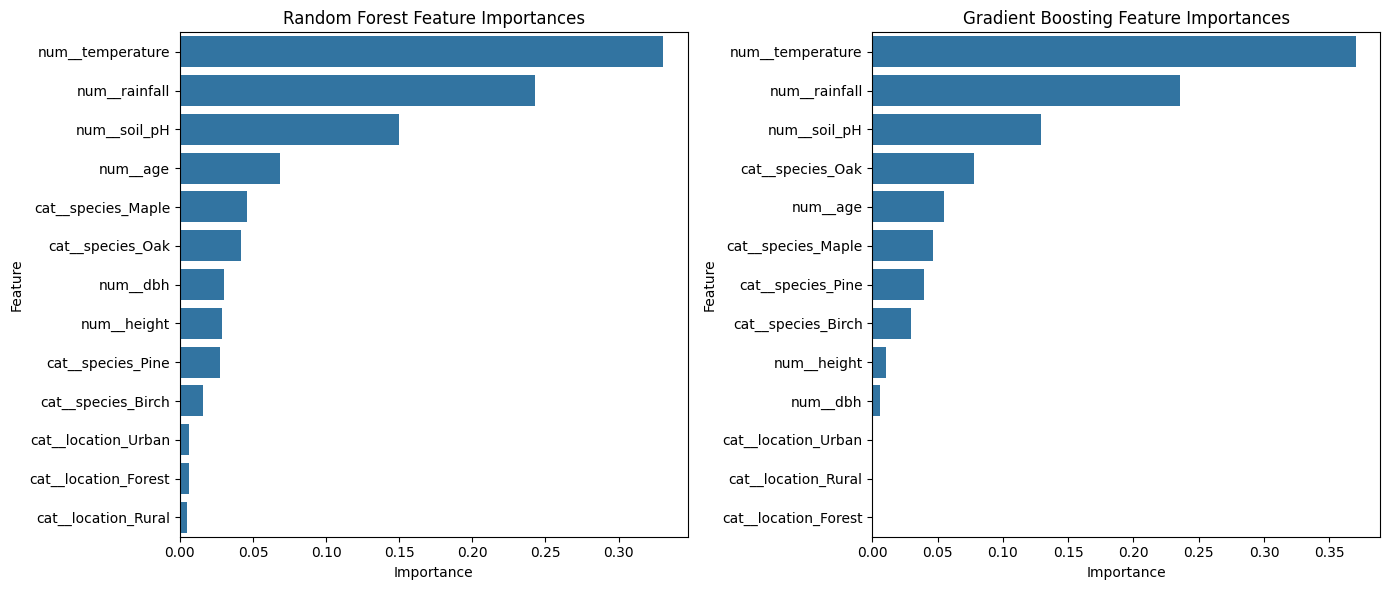

In [16]:
# Feature Importance
rf_feature_importance = pd.DataFrame({'Feature': preprocessor.get_feature_names_out(),
                                   'Importance': rf_model.feature_importances_})
rf_feature_importance = rf_feature_importance.reindex(rf_feature_importance.Importance.sort_values(ascending=False).index)

gbr_feature_importance = pd.DataFrame({'Feature': preprocessor.get_feature_names_out(),
                                   'Importance': gbr_model.feature_importances_})
gbr_feature_importance = gbr_feature_importance.reindex(gbr_feature_importance.Importance.sort_values(ascending=False).index)

fig, axs = plt.subplots(1, 2, figsize=(14,6))
sns.barplot(x="Importance", y="Feature", data=rf_feature_importance, ax=axs[0])
axs[0].set_title("Random Forest Feature Importances")
sns.barplot(x="Importance", y="Feature", data=gbr_feature_importance, ax=axs[1])
axs[1].set_title("Gradient Boosting Feature Importances")

plt.tight_layout()
plt.show()

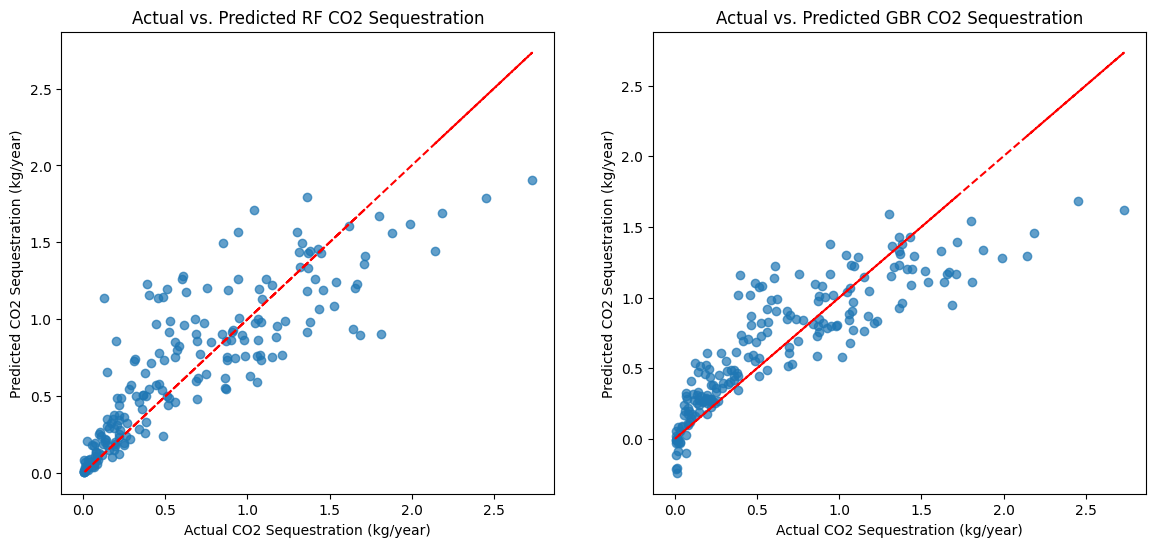

In [17]:
# Visualize prediction from both models
fig, axs = plt.subplots(1, 2, figsize=(14,6))

axs[0].scatter(y_test, rf_y_pred, alpha=0.7)
axs[0].set_xlabel("Actual CO2 Sequestration (kg/year)")
axs[0].set_ylabel("Predicted CO2 Sequestration (kg/year)")
axs[0].set_title("Actual vs. Predicted RF CO2 Sequestration")
axs[0].plot(y_test,y_test, color="red", linestyle="--")

axs[1].scatter(y_test, gbr_y_pred, alpha=0.7)
axs[1].set_xlabel("Actual CO2 Sequestration (kg/year)")
axs[1].set_ylabel("Predicted CO2 Sequestration (kg/year)")
axs[1].set_title("Actual vs. Predicted GBR CO2 Sequestration")
axs[1].plot(y_test,y_test, color="red", linestyle="--")

plt.show()